# Break AES using Differential Power Analysis with correlations
## i.e. CPA = Correlation Power Analysis

You need:
* `plaintext.txt`: all PT blocks, (one block per line, in hex, bytes separated by spaces)
* `ciphertext.txt`: all CT blocks, (one block per line, in hex, bytes separated by spaces)
* `traceLength.txt`: how many samples per trace (one decimal number)
* `traces.bin`: raw measured traces, one byte per sample (uint8), all traces together continuously


In [3]:
# !wget https://users.fit.cvut.cz/bucekj/dpa_student_v2.zip
# !unzip -j dpa_student_v2.zip
!ls

ciphertext.txt	dpa_bi-hwb_student5.nb	dpa_student_v2.zip  sample_data      traces.bin
dpa-aes-v.png	dpa_student.ipynb	plaintext.txt	    traceLength.txt


In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Warmup -- Numpy and array programming
"Array programming provides a powerful, compact and expressive syntax for accessing, manipulating and operating on data in vectors, matrices and higher-dimensional arrays."

In [5]:
# let us have two 2D arrays, i.e. matrices
a = np.array([[1, 2, 3], [4, 5, 6]])
b = np.array([[1, 1, 2], [2, 2, 3]])
print(a,  a.shape)
print(b)

[[1 2 3]
 [4 5 6]] (2, 3)
[[1 1 2]
 [2 2 3]]


In [6]:
# Add them together. Their dimensions are the same, so they are added element by element
c = a + b
print(c)

# We could of course add the elements manually. But this is cumbersome and not necessary
d = np.zeros((2, 3), dtype='int') # prepare a zero 2 x 3 array of integers for the result
for i in range(2):
    for j in range(3):
        d[i, j] = a[i, j] + b[i, j]
print(d)
print(c == d)
print(np.all(c == d))

[[2 3 5]
 [6 7 9]]
[[2 3 5]
 [6 7 9]]
[[ True  True  True]
 [ True  True  True]]
True


In [8]:
# Numpy broadcasting
print(a)
# A scalar is broadcast over the matrix
print(a - 20)
# We can add a matrix and a 1D (row) vector, as long as both have the same number of columns
print(a + np.array([10, 20, 30]))
x = np.array([10, 20, 30])
print(x.shape)
# The same happens if the added vector is 2D but still one row
print(a + np.array([[10, 20, 30]]))
y = np.array([[10, 20, 30]])
print(y.shape)

[[1 2 3]
 [4 5 6]]
[[-19 -18 -17]
 [-16 -15 -14]]
[[11 22 33]
 [14 25 36]]
(3,)
[[11 22 33]
 [14 25 36]]
(1, 3)


In [10]:
# Numpy broadcasting 2
print(b)
# Add 10 to the first row and 20 to the second row: Use a column vector
z = np.array([[10],[20]])
print(b + np.array([[10],[20]]))

[[1 1 2]
 [2 2 3]]
[[11 11 12]
 [22 22 23]]


In [12]:
print(x)
print(z)
print(x^z)

[10 20 30]
[[10]
 [20]]
[[ 0 30 20]
 [30  0 10]]


In [19]:
# Numpy broadcasting 3
print(a)
e = a[0, 1:2] # 1D vector from row 0 of matrix a
print(e)

f = np.array([10, 20])
f = np.array([[10], [20]]) # column vector
print(e * f)

[[1 2 3]
 [4 5 6]]
[2]
[[20]
 [40]]


In [23]:
print(a)
print(a.T)
g = a[:, 0]
print(g[ : , None])
print(g[ : , np.newaxis])

[[1 2 3]
 [4 5 6]]
[[1 4]
 [2 5]
 [3 6]]
[[1]
 [4]]
[[1]
 [4]]


## Useful functions and tables

In [24]:
# AES SBOX
sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
    ], dtype='uint8')

# Hamming weight lookup table
hw_table = []
for i in range(256):
    s = '{0:08b}'.format(i)
    hw_table.append(s.count('1'))
hw_table = np.array(hw_table, 'uint8')

# Correlation of two matrices
def correlate(x, y):
    """
    Correlate all columns from matrix x of shape (a,b)
    with all columns from matrix y of shape (a,c),
    creating correlation matrix C of shape (b,c).

    Originally matlab script by Jiri Bucek in NI-HWB.
    """
    x = x - np.average(x, 0) # remove vertical averages
    y = y - np.average(y, 0) # remove vertical averages
    C = x.T @ y              # (n-1) Cov(x,y)
    C = C / (np.sum(x**2, 0)**(1/2))[:,np.newaxis] # divide by (n-1) Var(x)
    C = C / (np.sum(y**2, 0)**(1/2))               # divide by (n-1) Var(y)
    return C

# Load PT of CT from file
def load_text(file_name):
    """
    Load any text PT/CT from file containing hex strings with bytes
    separated by spaces, one block per line
    Output is a matrix of bytes (np.array)
    """
    txt_str = open(file_name).readlines()
    if not txt_str[-1].strip():
        del txt_str[-1] #discard last empty line
    #split each line into bytes and convert from hex
    txt_bytes_list = list(
        map(lambda line:
                list(
                    map(lambda s: int(s, 16), # convert from hex
                        line.rstrip().split(" ")) # each byte separated by spaces
                ),
            txt_str)
        )
    return np.array(txt_bytes_list, 'uint8')

In [25]:
# read plaintext inputs
inputs = load_text("plaintext.txt")

# read length of one complete trace (number of samples per trace)
with open("traceLength.txt", "r") as fin:
  trace_length = int(fin.readline())

# trim each trace - select interesting part
tr_start = 0
tr_len = trace_length # CHANGE to the length of the first round;

# read traces from binary file -- the whole file at once, since it is quite small
traces = np.fromfile("traces.bin", dtype='uint8') # read as linear array
traces = np.reshape(traces, (traces.size // trace_length, trace_length)) # reshape into matrix
traces = traces[:, tr_start : tr_start + tr_len] # select only the interesting part of each trace

In [26]:
print(inputs.shape) # dimensions of inputs
print(trace_length)
print(traces.shape) # dimensions of matrix of traces

(100, 16)
200000
(100, 200000)


In [27]:
# Enable interactive zooming plots. Skip if it causes problems.
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except:
    pass # we are not in Google Colab, never mind
# We need ipympl for interactive plots
try:
    import ipympl
except:
    !pip install ipympl
# This finally enables interactive plots
%matplotlib widget
# %matplotlib notebook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.5 MB/s eta 0:00:00


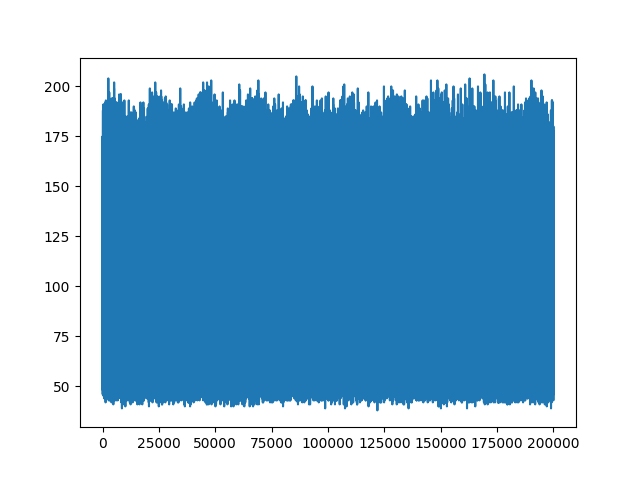

In [28]:
# Plot one trace
fig = plt.figure()
plt.plot(traces[0])
plt.show()

## **Attack the first key byte**
![Intermediate value](dpa-aes-v.png)


In [29]:
# Generate key hypotheses (all possible byte values)
keys = np.arange(start=0, stop=256, step=1, dtype='uint8')
# Select the first byte of each input block
input_byte = inputs[:, 0]
# XOR each data byte with each key (using Numpy broadcasting)
xmat = input_byte[:, np.newaxis] ^ keys

In [32]:
# Examine the inputs matrix. Does it contain the data from plaintext.txt?
print(inputs)
print(input_byte)
# What is the shape of all the operands from the previous cell?
print(f"{inputs.shape = }")
print(f"{input_byte.shape = }")
print(f"{input_byte[:, np.newaxis].shape = }")
print(f"{keys.shape = }")
print(f"{xmat.shape = }")
# Do you understand the values after the XOR operation? What AES operation do they represent?
print(xmat)

[[ 37 235 140 ...  71 237 252]
 [134  25 178 ... 142  50  68]
 [215 215 233 ...  61  22  57]
 ...
 [ 18 188 253 ...  68 197 189]
 [ 87 194  19 ... 160   8 136]
 [148 238  68 ...  23  94 218]]
[ 37 134 215   1 149  15  23  25 248  76  23  82  71  97 142  69 144  33
 109  44 188  79 206 178 123 252 219  91  82 230  53 144  27  46 149  87
 146 139 140  56 216  74  24 102   7  54 138  90 102 221 199  93  17 176
 180 189 233 113   0  46 104 239  41 251  23  30 155  36 129  20   1  15
 178 199 229  92   5 161 199 245  59   7  52 174 232 139 115  31 134 235
  85 180  71  78 228 192 189  18  87 148]
inputs.shape = (100, 16)
input_byte.shape = (100,)
input_byte[:, np.newaxis].shape = (100, 1)
keys.shape = (256,)
xmat.shape = (100, 256)
[[ 37  36  39 ... 216 219 218]
 [134 135 132 ... 123 120 121]
 [215 214 213 ...  42  41  40]
 ...
 [ 18  19  16 ... 239 236 237]
 [ 87  86  85 ... 170 169 168]
 [148 149 150 ... 105 106 107]]


In [33]:
# Substitute with SBOX all XORed values -- matrix of intermediate values
smat = sbox[xmat]
print(smat)
print(smat.shape)

[[ 63  54 204 ...  97 185  87]
 [ 68  23  95 ...  33 188 182]
 [ 14 246   3 ... 229 165  52]
 ...
 [201 125 202 ... 223 206  85]
 [ 91 177 252 ... 172 211 194]
 [ 34  42 144 ... 249   2 127]]
(100, 256)


In [34]:
# Compute Hamming Weights -- the matrix of hypothetical power consumption
hmat = hw_table[smat]
print(hmat)
print(hmat.shape)

[[6 4 4 ... 3 5 5]
 [2 4 6 ... 2 5 5]
 [3 6 2 ... 5 4 3]
 ...
 [4 6 4 ... 7 5 4]
 [5 4 6 ... 4 5 3]
 [2 3 2 ... 6 1 7]]
(100, 256)


In [35]:
# Compute the correlation matrix -- correlate the hypotheses with measured traces
print(hmat.shape)
print(traces.shape)
corr = correlate(hmat, traces)
print(corr, corr.shape)
# What is the shape and contents of the correlation matrix?

(100, 256)
(100, 200000)
[[-0.09996869 -0.08163088 -0.00677031 ...  0.04092881 -0.08513913
   0.11723421]
 [ 0.1493681   0.12922248  0.1232608  ... -0.06656259 -0.01887427
  -0.12409546]
 [ 0.08803485  0.02476164  0.13091204 ...  0.20924355  0.08109688
   0.06185696]
 ...
 [-0.02060608  0.15601015  0.07447815 ...  0.21329962 -0.09128557
  -0.13709434]
 [-0.07813509 -0.02154776 -0.0629129  ...  0.04557658 -0.04683356
   0.08107662]
 [-0.10571881 -0.08913038 -0.00789676 ... -0.04122821 -0.09576169
   0.02866201]] (256, 200000)


In [36]:
# Find the absolute maximum correlation
acorr = abs(corr)
max_acorr = acorr.max()
(k, j) = np.where(acorr == max_acorr) # find idices of maximum
print("key: %d time: %d" % (k[0], j[0]))
print("key: %1c, %02x" % (k[0], k[0]))

key: 222 time: 3348
key: Þ, de


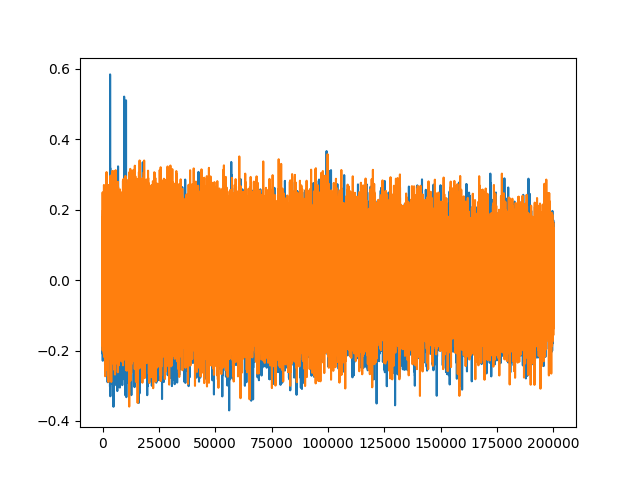

In [39]:
# Plot the correlation traces for the right key byte guess and one wrong key byte guess
# Do you see the correlation peaks?
fig = plt.figure()
plt.plot(corr[k[0]])
plt.plot(corr[1])
plt.show()

## **Break all key bytes!**

In [40]:
keys = np.array(range(0, 256))
kk = np.zeros(16, dtype='uint8')
for i in range(0, 16):
    input_byte = inputs[:, i]
    #????
    # XOR each data byte with each key (using Numpy broadcasting)
    xmat = input_byte[:, np.newaxis] ^ keys
    # Substitute with SBOX all XORed values -- matrix of intermediate values
    smat = sbox[xmat]
    # Compute Hamming Weights -- the matrix of hypothetical power consumption
    hmat = hw_table[smat]
    # Compute the correlation matrix -- correlate the hypotheses with measured traces
    corr = correlate(hmat, traces)
    # Find the absolute maximum correlation
    acorr = abs(corr)
    max_acorr = acorr.max()
    (k, j) = np.where(acorr == max_acorr) # find idices of maximum
    #????
    kk[i] = k
    print("%1c, %02x @ %d" % (k[0], k[0], j[0]))

Þ, de @ 3348
­, ad @ 15779
¾, be @ 3829
ï, ef @ 4045
 , 20 @ 4280
t, 74 @ 9180
o, 6f @ 4744
p, 70 @ 9064
 , 20 @ 5209
s, 73 @ 5441
e, 65 @ 5678
c, 63 @ 17859
r, 72 @ 17175
e, 65 @ 13170
t, 74 @ 6605
!, 21 @ 6837


## **Verify the key on a PT, CT pair!**

In [51]:
key_bytes = bytes(kk)
outputs = load_text("ciphertext.txt")
output_bytes = bytes(outputs)

In [53]:
# !pip install pycryptodome
from Crypto.Cipher import AES
cipher = AES.new(key_bytes, AES.MODE_ECB)
#??
input = load_text("plaintext.txt")
input_bytes = bytes(input)
ciphertext = cipher.encrypt(input_bytes)

print(output_bytes == ciphertext)

True
